# Create a LASSO model to predict TP53 mutation from gene expression data in TCGA

<FONT COLOR="FF00FF">
In order to track changes, modified parts will be preceded by comments in this color
</FONT>

<FONT COLOR="FF00FF">

<p align="justify">
LASSO stands for Least Absolute Shrinkage and Selection Operator. It can be seen as an extension of ordinary least squares. In ordinary least squares (OLS) method we minimize the error between our samples and those that are predicted. In OLS, there is no constraint for the estimated samples. Lasso adds a constraint that penalizes the sum of the absolute values of the estimates. In other words, it promotes sparsity of the output by forcing some of the estimates to be close to zero.  

Lasso model is optimizing the same objective function as the Elastic Net (implemented in TCGA-MLexample.ipynb) with l1_ratio=1.0 (no L2 penalty)
</p>

</FONT>

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

<FONT COLOR="FF00FF">
Importing the chosen model
</FONT>

In [2]:
from sklearn.linear_model import Lasso 

In [3]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [4]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53'

<FONT COLOR="FF00FF">
Defining number of features used and a grid for Lasso  parameters alpha and tolerance. 
alpha=0 corresponds to ordinary least squares 
</FONT>

In [5]:
# Parameter Sweep for Hyperparameters

n_feature_kept = 500

param_grid = {
    'alpha': [0.001, 0.01, 0.1],
    'tol' : [0.001, 0.01, 0.1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [6]:
if not os.path.exists('data'):
    os.makedirs('data')

In [7]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

In [8]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)

Wall time: 1min 56s


In [9]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

Wall time: 1min 41s


In [10]:
y = Y[GENE]

In [11]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: TP53, dtype: int64

In [12]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.655334
1    0.344666
Name: TP53, dtype: float64

## Set aside 10% of the data for testing

In [13]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,501 features, 6,935 training samples, 771 testing samples'

## Median absolute deviation feature selection

In [14]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline and Cross validation model fitting

<FONT COLOR="FF00FF">
Defining the Lasso model
</FONT>

In [15]:
clf = Lasso(random_state=0, max_iter=1000)

In [16]:
# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [17]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

Wall time: 26.5 s


C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\envs\cognoma-machine-learning\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


In [18]:
clf_grid.best_params_

{'alpha': 0.001, 'tol': 0.001}

In [19]:
best_clf

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.001, warm_start=False)

## Visualize hyperparameters performance

In [20]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [21]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,alpha,fold,score,tol
0,0.001,0,0.880705,0.001
1,0.001,1,0.894606,0.001


<FONT COLOR="FF00FF">
Two parameters are changed, tolerance parameter tol and regularization parameter alpha. Changes are made in corresponding labels in plots. 
</FONT>

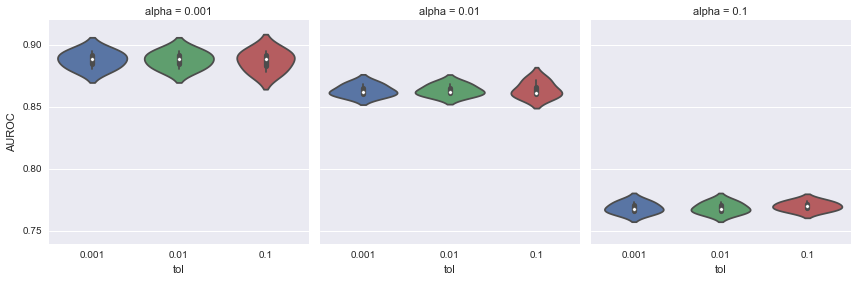

In [22]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='tol', y='score', col='alpha',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('AUROC');

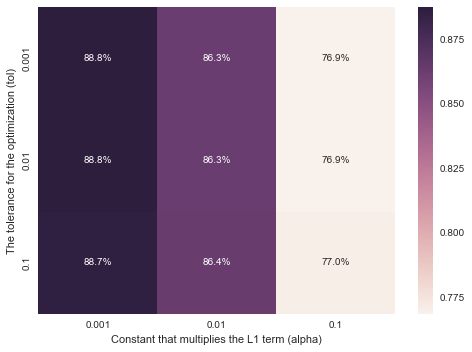

In [23]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='tol', columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Constant that multiplies the L1 term (alpha)')
ax.set_ylabel('The tolerance for the optimization (tol)');

## Use Optimal Hyperparameters to Output ROC Curve

In [24]:
y_pred_train = pipeline.decision_function(X_train)
y_pred_test = pipeline.decision_function(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\envs\cognoma-machine-learning\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\envs\cognoma-machine-learning\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


<FONT COLOR="FF00FF">
In TCGA-MLexample.ipynb two methods are used when presenting output results: decision_function and predict_proba. Lasso model does not have method predict_proba, hence it is removed from the code. Additionally, we obtain a warning that decision_function is going to be deprecated in future versions.
</FONT>

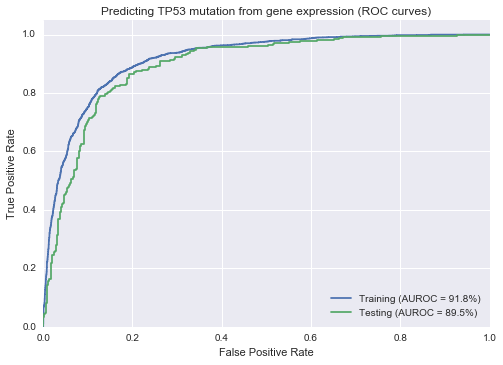

In [25]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

In [26]:
## What are the classifier coefficients?

In [27]:
coef_df = pd.DataFrame(best_clf.coef_.transpose(), index=X.columns[feature_mask], columns=['weight'])
coef_df['abs'] = coef_df['weight'].abs()
coef_df = coef_df.sort_values('abs', ascending=False)

In [28]:
'{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
    (coef_df.weight == 0).mean(),
    (coef_df.weight < 0).sum(),
    (coef_df.weight > 0).sum()
)

'26.6% zero coefficients; 186 negative and 181 positive coefficients'

In [29]:
coef_df.head(10)

,weight,abs
PVRL4,-0.065672,0.065672
MMP7,0.053833,0.053833
GPR158,0.048321,0.048321
FUT3,0.048068,0.048068
MLXIPL,0.045742,0.045742
C9orf152,0.045430,0.045430
HES2,-0.043839,0.043839
AFF3,-0.043483,0.043483
COL11A1,0.038526,0.038526
ATP10B,0.038344,0.038344


The results are not surprising. TP53 is a transcription modulator and when it mutated in a tumor, the cell goes haywire. This makes finding a transcriptional signature fairly easy. Also, the genes that the classifier uses is interesting, but not necessarily novel.

1. TP53 is a [transcription factor](https://en.wikipedia.org/wiki/Transcription_factor "TF wiki") that regulates many genes including EDA2R. Studies have linked EDA2R (or XEDAR) to [increased survival in colon cancer patients](http://www.ncbi.nlm.nih.gov/pubmed/19543321) and [losing hair as a result of chemotherapy](http://onlinelibrary.wiley.com/doi/10.1016/j.febslet.2010.04.058/full)
2. SPATA18 is a gene associated with spermatogenesis and is a transcription factor for TP53. It's association with TP53 was [recently discovered](http://www.ncbi.nlm.nih.gov/pubmed/21300779) in 2011.
3. C6orf138 (or [PTCHD4](http://www.genecards.org/cgi-bin/carddisp.pl?gene=PTCHD4)) is also a transcriptional target for TP53 and was only recently discovered in [2014 to repress hedgehog signalling](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4239647/).
4. The list goes on and includes several other TP53 targets...

## Investigate the predictions

In [30]:
predict_df = pd.DataFrame.from_items([
    ('sample_id', X.index),
    ('testing', X.index.isin(X_test.index).astype(int)),
    ('status', y),
    ('decision_function', pipeline.decision_function(X)),
])

C:\Users\bjokanov\AppData\Local\Continuum\Anaconda3\envs\cognoma-machine-learning\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


In [31]:
# Top predictions amongst negatives (potential hidden responders)
predict_df.sort_values('decision_function', ascending=False).query("status == 0").head(10)

,sample_id,testing,status,decision_function
sample_id,,,,
TCGA-CQ-A4CI-01,TCGA-CQ-A4CI-01,0,0,1.150689
TCGA-49-6743-01,TCGA-49-6743-01,1,0,1.057119
TCGA-B6-A0I1-01,TCGA-B6-A0I1-01,0,0,1.042365
TCGA-CV-5441-01,TCGA-CV-5441-01,1,0,1.035067
TCGA-GV-A40E-01,TCGA-GV-A40E-01,1,0,1.010269
TCGA-EI-6513-01,TCGA-EI-6513-01,0,0,1.004724
TCGA-CV-7261-01,TCGA-CV-7261-01,0,0,0.982802
TCGA-61-1907-01,TCGA-61-1907-01,0,0,0.982382
TCGA-E2-A574-01,TCGA-E2-A574-01,0,0,0.978704


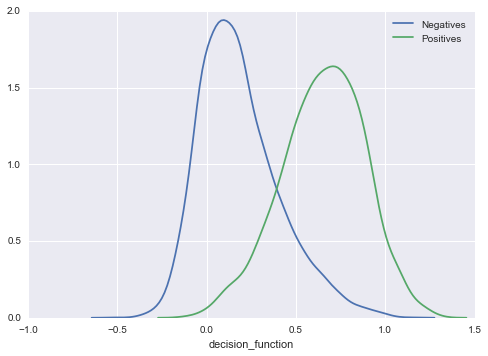

In [32]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')

ax = sns.distplot(predict_df.query("status == 0").decision_function, hist=False, label='Negatives')
ax = sns.distplot(predict_df.query("status == 1").decision_function, hist=False, label='Positives')